In [1]:
import click
import subprocess
from pathlib import Path
from functools import wraps
from ifsbench import Benchmark, DrHook, IFS, IFSNamelist, RunRecord, Workstation, NODEFile
from ifsbench.logging import logger, DEBUG
import metview as mv

## Set up the environemt

In [2]:
testdir = Path.cwd()
builddir = Path.cwd().parent
rundir = testdir/'rundir'
ifsdatadir = builddir/'ifsdata/40r1/40r1/ifsdata'

In [3]:
ifs = IFS(
    exec_name=builddir/'make/gnu-opt/oifs/bin/master.exe',
    builddir=builddir,
    nml_template=builddir/'ifsdata/namelist/namelist_40r1',
    eccodes_path='/usr/local/share/eccodes'
)

default_env = {
    'MPI_BUFS_PER_PROC': 256,
    'OMP_STACKSIZE': '128M',
    'OMP_SCHEDULE': 'STATIC',
}

## Configure IFS bench

In [4]:
def desmond_fc(fclen, tstep, nproc, nthread, arch, verbose, drhook):
    """
    Run the "Desmond" tutorial forecast.
    """

    class DesmondFC(Benchmark):
        """
        Definition of the input files for the Desmond forecast run
        """

        input_files = ['ICMGGgs0cINIT', 'ICMGGgs0cINIUA', 'ICMSHgs0cINIT', 'ICMCLgs0cINIT',
                       'rtables', '255l_2', 'wam_namelist',
                       'wam_grid_tables', 'wam_subgrid_0', 'wam_subgrid_1', 'wam_subgrid_2',
                       'sfcwindin', 'cdwavein', 'specwavein', 'uwavein']

        namelist = testdir/'desmond_fc.nml'

    if verbose:
        logger.setLevel(DEBUG)

    drhook = DrHook.PROF if drhook else DrHook.OFF

    benchmark = DesmondFC.from_files(expid='gs0c', ifs=ifs, rundir=rundir,
                                     srcdir=[testdir/'data', builddir/'ifsdata/40r1',
                                             builddir/'ifsdata/40r1/40r1/climate'],
                                     ifsdata=ifsdatadir)
    benchmark.check_input()  

    # Execute benchmark with given options and read RunRecord object
    record = benchmark.run(namelist=benchmark.namelist,
                           fclen=fclen, tstep=tstep,
                           arch=arch, nproc=nproc, nthread=nthread,
                           env=default_env.copy(), drhook=drhook)


## Run OIFS with the configured namelists

In [5]:
desmond_fc(fclen=None, tstep=None, nproc=8, nthread=2, arch=None, verbose=True, drhook=False)

More than one input file 255l_2 found in (PosixPath('/oifs/desmond_py_copy2/data'), PosixPath('/oifs/ifsdata/40r1'), PosixPath('/oifs/ifsdata/40r1/40r1/climate'))
[ifsbench] User env:
{ 'DATA': PosixPath('/oifs/desmond_py_copy2/rundir'),
  'DR_HOOK': '0',
  'ECCODES_DEFINITION_PATH': PosixPath('/usr/local/share/eccodes/definitions'),
  'GRIB_DEFINITION_PATH': PosixPath('/usr/local/share/eccodes/definitions'),
  'GRIB_SAMPLES_PATH': PosixPath('/usr/local/share/eccodes/ifs_samples/grib1_mlgrib2'),
  'LD_LIBRARY_PATH': PosixPath('/oifs/ifs-source'),
  'MPI_BUFS_PER_PROC': 256,
  'NPROC': 8,
  'NPROC_IO': 0,
  'OMP_NUM_THREADS': 2,
  'OMP_SCHEDULE': 'STATIC',
  'OMP_STACKSIZE': '128M'}
[ifsbench] Run directory: /oifs/desmond_py_copy2/rundir
[ifsbench] Executing: mpirun -np 8 /oifs/make/gnu-opt/oifs/bin/master.exe -e gs0c


In [6]:
res = subprocess.run(["cd rundir; ./convert_to_grib.sh"], shell=True)

## Hovmoeller Temperature plot

In [8]:
t_ts = mv.read("./rundir/finaldata/t2_20151203.grib")

In [9]:
time_axis = mv.maxis(
    axis_type                = "date",
    axis_years_label_height  = 0.3,
    axis_months_label_height = 0.3,
    axis_days_label_height   = 0.3
)

In [10]:
hovmoeller_view = mv.mhovmoellerview(
    type              = "area_hovm",
    area              = [53.4,-58.9,67.2,118.1],
    average_direction = "north_south",
    time_axis         = time_axis
    )

In [11]:
shade = mv.mcont(
    legend                      = "on",
    contour                     = "off",
    contour_level_count         = 8,
    contour_label               = "off",
    contour_shade               = "on",
    contour_shade_colour_method = "list",
    contour_shade_method        = "area_fill",
    contour_shade_colour_list   = ["blue", "sky", "blue_green", "grey", "cream",
                                   "yellowish_orange", "reddish_orange", "red"]
)


In [12]:
title = mv.mtext(
    text_font_size = 0.5
)

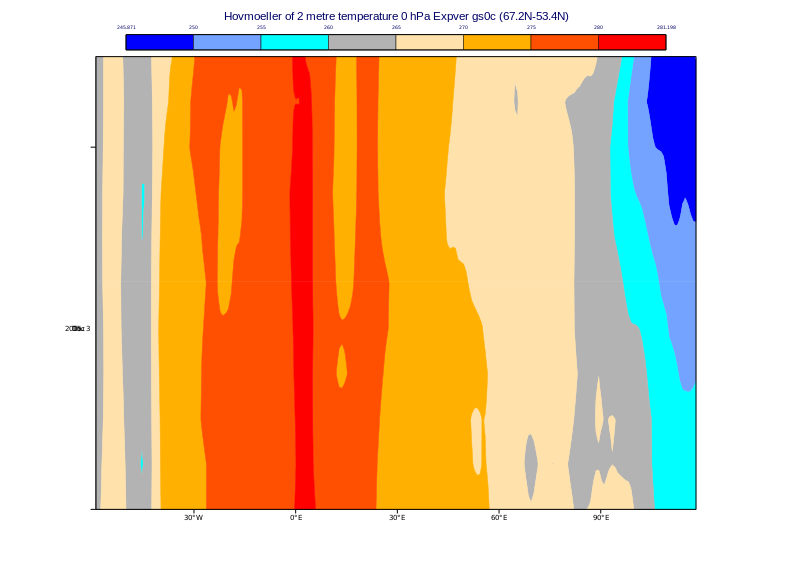

In [13]:
mv.setoutput('jupyter')
mv.plot(hovmoeller_view, t_ts, shade, title)

## Temperature time series

In [14]:
t = mv.read('./rundir/finaldata/t2_20151203.grib')

In [15]:
t2m = mv.read(data = t, param = '2t') - 273.15

In [16]:
area = [75,-12.5,35,42.5] # N,W,S,E
t2m_int = mv.integrate(t2m, area)

In [17]:
print('t2m integrals: ', t2m_int)

t2m integrals:  [6.124953836992217, 5.228546703475996, 4.809699582242543, 5.738019489593688, 7.045231537712939, 6.637982803924258, 5.807068330692772, 5.16080811021295, 4.729381573454094, 4.410468178648594, 4.32484284875274]


In [18]:
times_t2m = mv.valid_date(t2m)

In [19]:
haxis = mv.maxis(axis_type = 'date',
                 axis_years_label_height = 0.45,
                 axis_months_label_height = 0.45,
                 axis_days_label_height = 0.45)
 
vaxis = mv.maxis(axis_title_text = 'Temperature, K',
                 axis_title_height = 0.5)
 
ts_view = mv.cartesianview(
    x_automatic = "on",
    x_axis_type = "date",
    y_automatic = "on",
    horizontal_axis = haxis,
    vertical_axis   = vaxis)
 
curve_2t = mv.input_visualiser(
    input_x_type        = "date",
    input_date_x_values = times_t2m,
    input_y_values      = t2m_int)

In [20]:
common_graph = {'graph_line_thickness' : 2, 'legend' : 'on'}
graph_2t = mv.mgraph(common_graph, graph_line_colour = 'black', legend_user_text = 't2m')

In [21]:
legend = mv.mlegend(legend_display_type = 'disjoint', legend_text_font_size = 0.5)

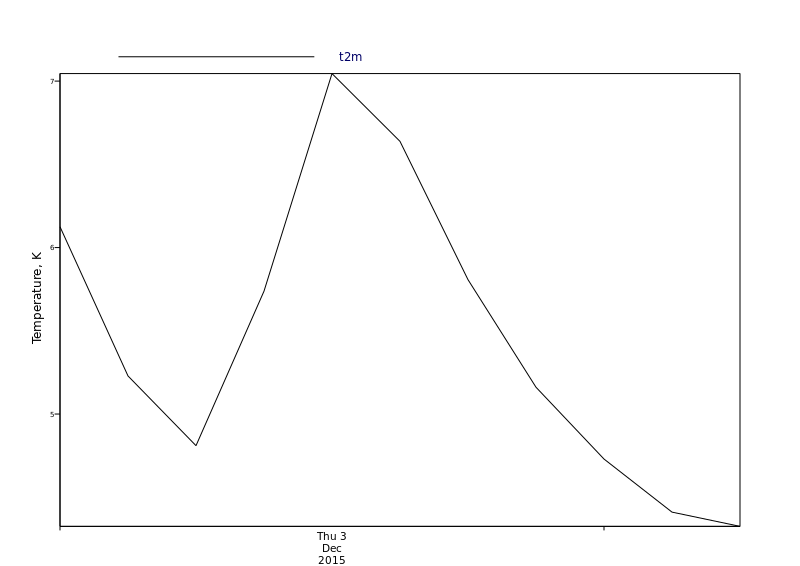

In [22]:
mv.plot(ts_view, curve_2t, graph_2t,legend)
